Had been using CDEC, but need to switch to WDL
Compare them, to see if we expect any changes.

Found that CDEC appears to use local time, including changes between PST and
PDT.
WDL appears to be consistently PST.

WDL has flow on all 3 sides, but no stage data.

USGS stage data from several km downstream confirms that the CDEC stage 
data has the same PST/PDT switching as other CDEC datastreams, and
that the gage datum for stage is not hugely different from NAVD88.

Not a very strong check, though.

Next steps:
 1. Update CDEC code to apply time zone shifts.
 2. Potentially compare CDEC stage and ADCP transecting to understand
    how to make the ADCP data consistent with both flow and stage.

In [21]:
import numpy as np
from stompy import utils
import matplotlib.pyplot as plt
import pandas as pd
from stompy.io.local import cdec,usgs_nwis
import os
%matplotlib notebook

In [22]:
# Go back to Mar 1, since PDT began on 3/11
start_date=np.datetime64("2018-03-01")
end_date  =np.datetime64("2018-04-15")
cache_dir="cache"

Q_upstream=cdec.cdec_dataset(station="MSD",
                             start_date=start_date,end_date=end_date,
                             sensor=20,
                             cache_dir=cache_dir)

Q_downstream=cdec.cdec_dataset(station="SJD",
                               start_date=start_date,end_date=end_date,
                               sensor=20,
                               cache_dir=cache_dir)

stage_or=cdec.cdec_dataset(station="OH1",
                           start_date=start_date,end_date=end_date,
                           sensor=1,
                           cache_dir=cache_dir)

In [23]:
# Water data library:
# MSD flows
local_file=os.path.join(cache_dir,"msd-flow-2018.csv")

utils.download_url(local_file=local_file,
                   url=("http://wdl.water.ca.gov/waterdatalibrary/docs/"
                        "Hydstra/docs/B95820Q/2018/FLOW_15-MINUTE_DATA_DATA.CSV") )
                                 
msd_flow=pd.read_csv(local_file,skiprows=3,parse_dates=['time_pst'],
                     names=['time_pst','flow_cfs','quality','notes'])
msd_flow['time']=msd_flow['time_pst'] + np.timedelta64(8,'h')

In [24]:
local_file=os.path.join(cache_dir,"oh1-flow-2018.csv")

utils.download_url(local_file=local_file,
                   url=("http://wdl.water.ca.gov/waterdatalibrary/docs/Hydstra/"
                        "docs/B95400Q/2018/FLOW_15-MINUTE_DATA_DATA.CSV") )

oh1_flow=pd.read_csv(local_file,skiprows=3,parse_dates=['time_pst'],
                     names=['time_pst','flow_cfs','quality','notes'])
oh1_flow['time']=oh1_flow['time_pst'] + np.timedelta64(8,'h')

In [25]:
local_file=os.path.join(cache_dir,"sjd-flow-2018.csv")

utils.download_url(local_file=local_file,
                   url=("http://wdl.water.ca.gov/waterdatalibrary/docs/Hydstra/"
                        "docs/B95760/2018/FLOW_15-MINUTE_DATA_DATA.CSV") )

sjd_flow=pd.read_csv(local_file,skiprows=3,parse_dates=['time_pst'],
                     names=['time_pst','flow_cfs','quality','notes'])
sjd_flow['time']=sjd_flow['time_pst'] + np.timedelta64(8,'h')


In [26]:
# USGS has stage, with NAVD88 datum, downstream:
# USGS 11304810 SAN JOAQUIN R BL GARWOOD BRIDGE A STOCKTON CA
garwood=usgs_nwis.nwis_dataset(station=11304810, 
                               start_date=start_date,end_date=end_date,
                               products=[65],
                               cache_dir=cache_dir)

# Vernalis gage datum is 25 ft above NGVD29.  Thanks.
vernalis=usgs_nwis.nwis_dataset(station=11303500, 
                               start_date=start_date,end_date=end_date,
                               products=[65],
                               cache_dir=cache_dir)



<IPython.core.display.Javascript object>


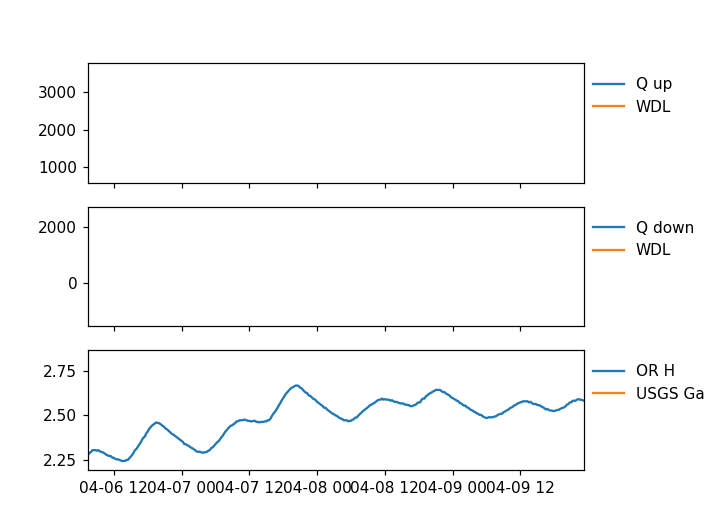

(736762.8268733375, 736766.0269683164, -1550.0, 2708.0)

In [28]:
import six

fig,axs=plt.subplots(3,1,sharex=True)

axs[0].plot( Q_upstream.time,  Q_upstream.sensor0020, label='Q up')
axs[0].plot( msd_flow.time, msd_flow.flow_cfs, label='WDL')

axs[1].plot( Q_downstream.time,Q_downstream.sensor0020, label='Q down')
axs[1].plot( sjd_flow.time, sjd_flow.flow_cfs, label='WDL')

axs[2].plot( stage_or.time,    stage_or.sensor0001*0.3048, label='OR H')
axs[2].plot( garwood.time, garwood.height_gage*0.3048, label='USGS Garwood')
#axs[2].plot( vernalis.time, vernalis.height_gage, label='USGS Vernalis')


for ax in axs:
    ax.legend(loc='upper left',bbox_to_anchor=(0.99,1),frameon=0)
fig.subplots_adjust(right=0.83)

#axs[0].axis(xmin=start_date,xmax=end_date)
axs[0].axis((736762.8268733375, 736766.0269683164, 583.3341280134609, 3759.149636949731))
axs[1].axis(ymin=-1550., ymax=2708.)

In [11]:
axs[1].axis()

(736762.8268733375, 736766.0269683164, -1550.8361761329988, 2708.664723042206)

<IPython.core.display.Javascript object>


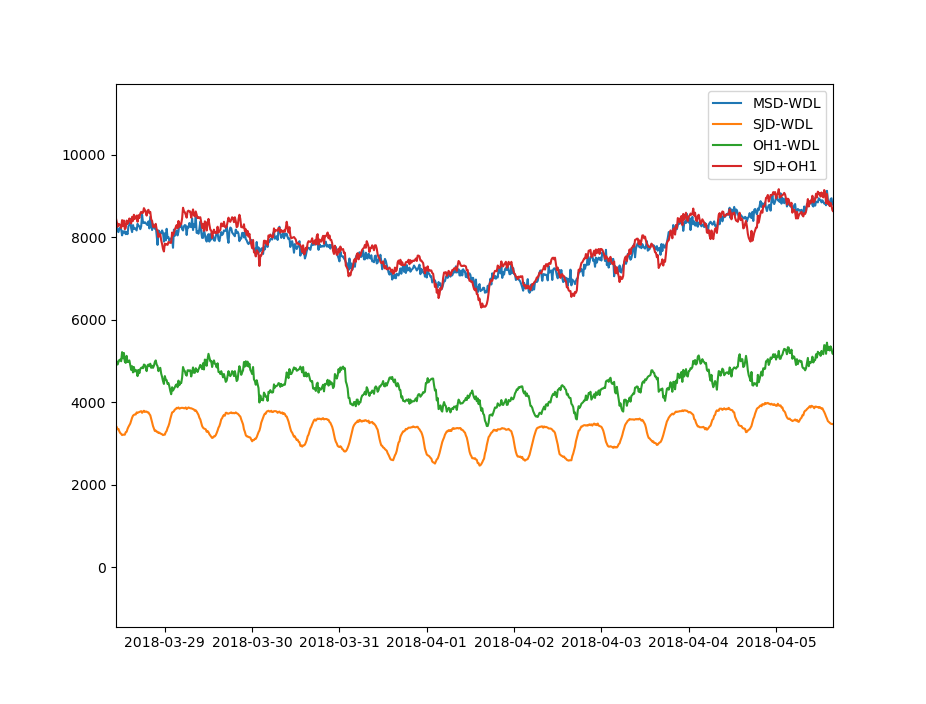

In [42]:
# Also compare MSD and the sum of the two downstream flows as
# a check on possible MSD bias.
fig,ax=plt.subplots(1,1)


ax.plot( msd_flow.time, msd_flow.flow_cfs, label='MSD-WDL')
ax.plot( sjd_flow.time, sjd_flow.flow_cfs, label='SJD-WDL')
ax.plot( oh1_flow.time, oh1_flow.flow_cfs, label='OH1-WDL')

sjd_i=np.interp( utils.to_dnum(msd_flow.time),
                 utils.to_dnum(sjd_flow.time), sjd_flow.flow_cfs )
oh1_i=np.interp( utils.to_dnum(msd_flow.time),
                 utils.to_dnum(oh1_flow.time), oh1_flow.flow_cfs )

bal=sjd_i+oh1_i
ax.plot( msd_flow.time, bal, label='SJD+OH1')

ax.legend()